In [132]:
import sklearn
import torch as th
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
import pandas as pd
import gzip
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
import gzip

fp = gzip.open('fashion-mnist.pk.gz','rb')
Xtrain, Ytrain, Xtest, Ytest, classlist  = pickle.load(fp)

Xtrain_N = th.from_numpy(StandardScaler().fit_transform(Xtrain)).float()
Xtrain_N=Xtrain_N.type(th.FloatTensor)
Xtrain_N=Xtrain_N.cuda()
Xtest_N = th.from_numpy(StandardScaler().fit_transform(Xtest)).float()
Xtest_N=Xtest_N.type(th.FloatTensor)
Xtest_N=Xtest_N.cuda()

In [3]:
Ytrain = Ytrain.cuda()
Ytest = Ytest.cuda()


In [4]:
# Training function

def train(model,optimizer,loss_fn,epochs,batch_size,Xtrain,Ytrain,Xtest,Ytest,verbose=False):
    ### Mini-batching and shuffle
    Ntrain = Xtrain.shape[0]
    Nvalid = Xtest.shape[0]
    idx = np.arange(Ntrain)              # Number of samples that we treat before update the gradient such as in descent gradient, a trade-off between batch and gradient descent methods
    nbatch = int(Ntrain/batch_size)

    train_losses,valid_losses, valid_accuracies=[],[],[]
    for e in range(epochs):
        np.random.shuffle(idx)
        running_loss=0
        totaln = 0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            images = Xtrain[ids]
            labels = Ytrain[ids]
            totaln += labels.shape[0] # the number of samples
            optimizer.zero_grad()
            logprobs=model(images)
            loss=loss_fn(logprobs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        # training is over for one epoch
        # now compute interesting quantities
        accuracy=0
        valid_loss = 0
        with th.no_grad(): # From here, we ignore the gradient in calculations with tensors, which will increase the speed of the code
            images = Xtest.cuda()   # We are going to valid the model
            labels = Ytest.cuda()
            logprobs=model(images).cuda()
            valid_loss=loss_fn(logprobs,labels)
            top_p,top_class=logprobs.topk(1)   # topk function will take the predicted class according to the model that we used
            accuracy=(top_class.T == labels).sum().float()
        train_losses.append(running_loss/batch_size)
        valid_losses.append(valid_loss)
        valid_accuracies.append(accuracy.item()*100.0/Nvalid)
        #print("Epoch: {}\t".format(e),"train Loss: {:.5f}.. ".format(train_losses[-1]), "valid Loss: {:.5f}.. ".format(valid_losses[-1]),"valid Accuracy: {:.3f}".format(valid_accuracies[-1]))
    #print("---------- Best : {:.3f}".format(max(valid_accuracies)), " at epoch " , np.fromiter(valid_accuracies, dtype=np.float).argmax(), " / ",epochs )
    print('Training/Testing done !!')
    return max(valid_accuracies) , np.fromiter(valid_accuracies, dtype=np.float).argmax()

In [5]:
x_train = th.reshape(Xtrain_N,(60000,1,28,28))
x_test = th.reshape(Xtest_N,(10000,1,28,28))

In [6]:
print(x_train.shape)
print(x_test.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


In [7]:
# Convolutional layer

In [8]:
epochs = 40
batch_size = 1000
D_out = 10
MAX_ACC, IN_EPOCH, FILTERS = [], [], []

for k in range(1,40):
    D_in = k*21*21
    model = nn.Sequential(nn.Conv2d(1, k, kernel_size=5, stride=1),#1000xkx24x24
                    nn.MaxPool2d(4, stride=1), #100xkx21x21
                    nn.Flatten(), # 1000x(k*21*21)
                    nn.Linear(D_in,D_out), #10
                    nn.LogSoftmax(dim=1)
                    ).cuda()
    optimizer=th.optim.Adam(model.parameters(),lr=0.001)
    loss_fn=nn.NLLLoss()
    max_acc, EPOCH = train(model,optimizer,loss_fn,epochs,batch_size,x_train,Ytrain,x_test,Ytest)
    MAX_ACC.append(max_acc)
    IN_EPOCH.append(EPOCH)
    FILTERS.append(k)

Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!
Training/Testing done !!


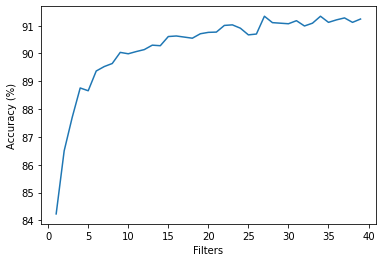

The best accuracy was 91.34 % for 27 Filters


In [9]:

plt.plot(FILTERS,MAX_ACC)
plt.xlabel('Filters')
plt.ylabel('Accuracy (%)')
plt.show()
print('The best accuracy was' , max(MAX_ACC),'% for',  FILTERS[MAX_ACC.index(max(MAX_ACC))], 'Filters')

In [42]:
x_train.shape[0]
idx = np.arange(x_train.shape[0])
nbatch = int(x_train.shape[0]/batch_size)
print(nbatch)

60


In [47]:
# Getting predictions to construct a confusion matrix
@th.no_grad()
def get_predictions(model, data_x,data_y, batch_size):
    all_preds = th.Tensor([]).cuda()
    N = data_x.shape[0]
    idx = np.arange(N)
    nbatch = int(N/batch_size)
    for bi in range(nbatch):  
        ids = idx[bi*batch_size:(bi+1)*batch_size]
        images = data_x[ids]
        labels = data_y[ids]
        preds = model(images).cuda()
        all_preds = th.cat((all_preds,preds),dim = 0)
    return all_preds

In [106]:
def preds_correct(data_y,preds):
    ac=(preds.argmax(dim = 1) == data_y).sum().float()
    return(ac.item())


In [107]:
train_preds = get_predictions(model, x_train,Ytrain, batch_size= 1000)
print('Total correct labels: ', preds_correct(Ytrain,train_preds))
print('With an accuraccy of: ', preds_correct(Ytrain,train_preds)/len(x_train) * 100,'%')

Total correct labels:  57347.0
With an accuraccy of:  95.57833333333333 %


In [112]:
test_preds = get_predictions(model,x_test,Ytest,batch_size = 1000)
print('Total correct labels: ', preds_correct(Ytest,test_preds))
print('With an accuracy of: ', preds_correct(Ytest,test_preds)/len(x_test) * 100,'%')
test_preds.shape

Total correct labels:  9027.0
With an accuracy of:  90.27 %


torch.Size([10000, 10])

In [117]:
stacked_train = th.stack( (Ytrain,train_preds.argmax(dim = 1)),dim = 1)
stacked_test = th.stack( (Ytest, test_preds.argmax(dim = 1)), dim = 1)

In [120]:
# Confusion matrix

def Confusion_Matrix(x_data,y_data,model,batch_size):
    preds = get_predictions(model,x_data,y_data,batch_size)
    stacked = th.stack( (y_data,preds.argmax(dim=1)), dim = 1)
    cmt = th.zeros(10,10, dtype = th.int32)
    for p in stacked:
        TL, PL = p.tolist()
        cmt[TL, PL] = cmt[TL, PL] + 1
    return(cmt)

In [142]:
cm_train = Confusion_Matrix(x_train,Ytrain,model,batch_size = 1000).numpy()
cm_test = Confusion_Matrix(x_test,Ytest,model,batch_size = 1000).numpy()

In [143]:
def plot_confusion_matrix(cm,classes,normalize = False,cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis = 1 )[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix without normalization')
    print(cm)
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks= np.arange(len(classes))
    plt.xticks(tick_marks,classes, rotation = 45)
    plt.yticks(tick_marks,classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i, format(cm[i,j],fmt),
        horizontalalignment='center', color = 'white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Confusion matrix without normalization
[[5234    0   30   59    2    0  674    0    1    0]
 [   0 5996    0    4    0    0    0    0    0    0]
 [  26    0 5539   19   63    0  353    0    0    0]
 [  17    8   11 5797   50    0  117    0    0    0]
 [   4    2  307   45 5121    0  521    0    0    0]
 [   0    0    0    0    0 5999    0    1    0    0]
 [ 124    1   94   39   29    0 5713    0    0    0]
 [   0    0    0    0    0    2    0 5975    0   23]
 [   1    0    0    1    1    0    5    0 5992    0]
 [   0    0    0    0    0    1    0   18    0 5981]]


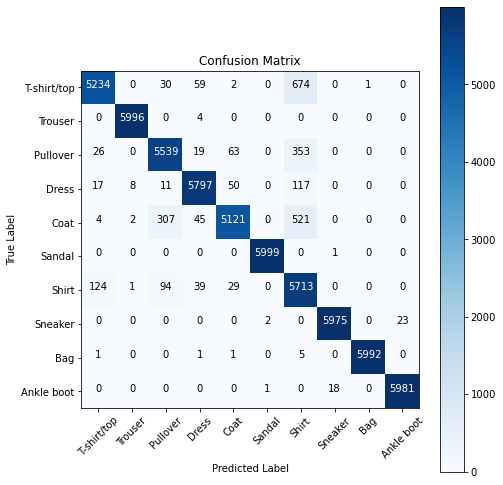

In [144]:
names = ('T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot')
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm_train,names)

Confusion matrix without normalization
[[806   0  18  14   4   1 149   0   8   0]
 [  2 985   1   9   1   0   2   0   0   0]
 [ 17   2 840   6  32   0 102   0   1   0]
 [  5   7  18 895  18   0  54   0   3   0]
 [  0   1  88  25 762   0 123   0   1   0]
 [  0   0   0   0   0 989   0   8   1   2]
 [ 70   0  40  19  34   0 832   0   5   0]
 [  0   0   0   0   0   5   0 976   1  18]
 [  5   1   4   4   0   2   8   1 975   0]
 [  0   0   0   0   0   7   1  25   0 967]]


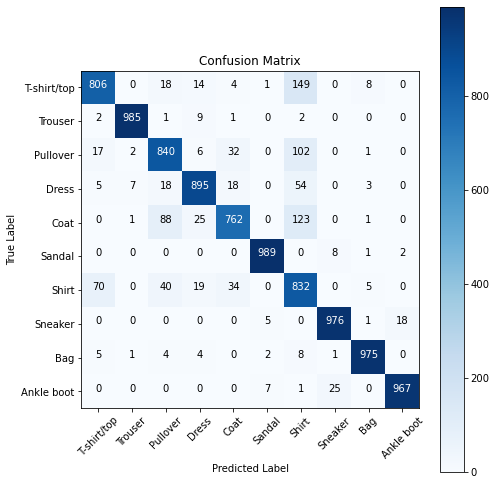

In [146]:
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm_test,names)